In [1]:
import akshare as ak

In [9]:
now = datetime.datetime.now().date()
start = now - datetime.timedelta(days=365*4)

start_date = start.strftime("%Y%m%d")
end_date = now.strftime("%Y%m%d")

print(start_date)
print(end_date)
# 通过akshare获取中证1000日线数据（近1000天）
bars = ak.index_zh_a_hist(symbol="000852", start_date=start_date, end_date=end_date)

bars.rename(columns = {
    "日期": "date",
    "开盘": "open",
    "最高": "high",
    "最低": "low",
    "收盘": "close",
    "成交量":"volume"
}, inplace=True)

bars["date"] = pd.to_datetime(bars["date"])
bars.set_index("date", inplace=True)

bars["flag"] = np.select([bars["close"] > bars["open"], 
                          bars["close"] < bars["open"]], 
                          [1, -1], 
                          0)
bars.tail()

20201120
20241119


,open,close,high,low,volume,成交额,振幅,涨跌幅,涨跌额,换手率,flag
date,,,,,,,,,,,
2024-11-13,6453.86,6474.39,6512.60,6357.56,317485928,4.203869e+11,2.39,-0.27,-17.58,3.33,1
2024-11-14,6462.01,6272.19,6472.95,6263.31,294794718,3.878677e+11,3.24,-3.12,-202.20,3.09,-1
2024-11-15,6246.34,6125.51,6331.87,6124.66,295191634,3.834241e+11,3.30,-2.34,-146.68,3.09,-1
2024-11-18,6154.51,5974.56,6180.88,5937.09,322672608,3.740080e+11,3.98,-2.46,-150.95,3.38,-1
2024-11-19,5977.84,6130.28,6130.50,5945.46,273167526,3.279243e+11,3.10,2.61,155.72,2.86,1


In [3]:
def find_runs(x):
    """Find runs of consecutive items in an array.
    """

    # ensure array
    x = np.asanyarray(x)
    if x.ndim != 1:
        raise ValueError("only 1D array supported")
    n = x.shape[0]

    # handle empty array
    if n == 0:
        return np.array([]), np.array([]), np.array([])

    else:
        # find run starts
        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True
        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_starts = np.nonzero(loc_run_start)[0]

        # find run values
        run_values = x[loc_run_start]

        # find run lengths
        run_lengths = np.diff(np.append(run_starts, n))

        return run_values, run_starts, run_lengths

In [4]:
v, s, l = find_runs(bars["flag"] == -1)

cum_neg_returns = []
for vi, si, li in zip(v, s, l):
    if vi and li > 1:
        cum_neg_returns.append((bars.index[si], 
                                bars.index[si + li-1], 
                                bars.close[si + li -1 ]/bars.open[si] - 1))
        
r = pd.DataFrame(cum_neg_returns, columns=["start", "end", "cnr"])
r

,start,end,cnr
0,2020-11-25,2020-11-26,-0.025388
1,2020-12-07,2020-12-09,-0.023310
2,2020-12-28,2020-12-29,-0.012879
3,2021-01-06,2021-01-11,-0.048171
4,2021-01-22,2021-01-26,-0.029975
...,...,...,...
103,2024-08-20,2024-08-22,-0.036867
104,2024-09-06,2024-09-09,-0.024712
105,2024-09-12,2024-09-18,-0.020352
106,2024-10-08,2024-10-11,-0.158511


<Axes: >

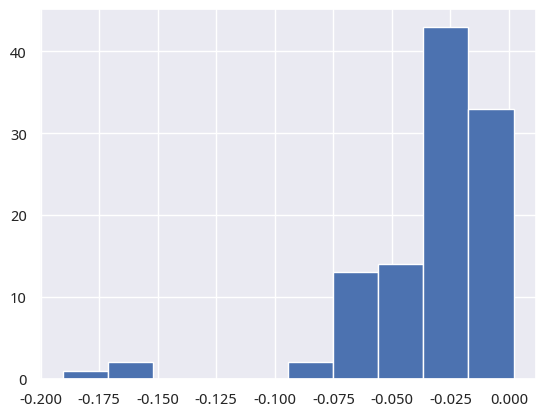

In [5]:
r.cnr.hist()

In [6]:
r.nsmallest(10, "cnr").sort_values("end", ascending=False)

,start,end,cnr
107,2024-11-14,2024-11-18,-0.075433
106,2024-10-08,2024-10-11,-0.158511
89,2024-03-21,2024-03-27,-0.071948
88,2024-01-26,2024-02-05,-0.190592
87,2024-01-19,2024-01-22,-0.067846
78,2023-10-16,2023-10-23,-0.074109
45,2022-09-15,2022-09-19,-0.066983
37,2022-04-20,2022-04-26,-0.170335
34,2022-03-14,2022-03-15,-0.066983
33,2022-03-03,2022-03-09,-0.086669


In [13]:
# 3/27这一次下跌0.0694，此后继续下跌的概率

p_decline = r.cnr.le(-0.075433).mean()
p_decline

0.046296296296296294

In [14]:
# 4/16这一次下跌0.058，此后继续下跌的概率

p_decline = r.cnr.le(-0.058228).mean()
p_decline

0.1452991452991453

In [14]:
import numpy as np
for loss in np.linspace(-0.05, -0.1, 10):
    print(f"下跌幅度{loss:.1%}, 反弹概率: {1- r.cnr.le(loss).mean():.1%}")

下跌幅度-5.0%, 反弹概率: 81.5%
下跌幅度-5.6%, 反弹概率: 83.3%
下跌幅度-6.1%, 反弹概率: 87.0%
下跌幅度-6.7%, 反弹概率: 89.8%
下跌幅度-7.2%, 反弹概率: 94.4%
下跌幅度-7.8%, 反弹概率: 96.3%
下跌幅度-8.3%, 反弹概率: 96.3%
下跌幅度-8.9%, 反弹概率: 97.2%
下跌幅度-9.4%, 反弹概率: 97.2%
下跌幅度-10.0%, 反弹概率: 97.2%


In [27]:
data = []
for loss in np.linspace(-0.06, -0.076, 15):
    data.append((loss, 1- r.cnr.le(loss).mean()))

df = pd.DataFrame(data, columns=['最大亏损', '抄底胜率'])
df.style.format("{:.1%}")

,最大亏损,抄底胜率
0,-6.0%,87.0%
1,-6.1%,87.0%
2,-6.2%,87.0%
3,-6.3%,87.0%
4,-6.5%,88.0%
5,-6.6%,89.8%
6,-6.7%,90.7%
7,-6.8%,93.5%
8,-6.9%,93.5%
9,-7.0%,93.5%
